Student Information
Name: 朱育欣

Student ID: 111062653

GitHub ID: hanssel519

Kaggle name: winnie hanssel chu

Kaggle private scoreboard snapshot:

Snapshot

Instructions
First: This part is worth 30% of your grade. Do the take home exercises in the DM2022-Lab2-master Repo. You may need to copy some cells from the Lab notebook to this notebook.

Second: This part is worth 30% of your grade. Participate in the in-class Kaggle Competition regarding Emotion Recognition on Twitter by this link https://www.kaggle.com/t/2b0d14a829f340bc88d2660dc602d4bd. The scoring will be given according to your place in the Private Leaderboard ranking:

Bottom 40%: Get 20% of the 30% available for this section.

Top 41% - 100%: Get (60-x)/6 + 20 points, where x is your ranking in the leaderboard (ie. If you rank 3rd your score will be (60-3)/6 + 20 = 29.5% out of 30%)

Submit your last submission __BEFORE the deadline (Nov. 22th 11:59 pm, Tuesday)_. Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the img folder of this repository and rerun the cell Student Information.

Third: This part is worth 30% of your grade. A report of your work developping the model for the competition (You can use code and comment it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained.

Fourth: This part is worth 10% of your grade. It's hard for us to follow if your code is messy :'(, so please tidy up your notebook and add minimal comments where needed.

Upload your files to your repository then submit the link to it on the corresponding e-learn assignment.

Make sure to commit and save your changes to your repository BEFORE the deadline (Nov. 25th 11:59 pm, Friday).

In [1]:
# libraries import
import os
import re
import time
import math
import json
import string
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import KeyedVectors

2022-11-25 00:34:32.446462: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-25 00:34:32.516023: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-25 00:34:32.532880: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-25 00:34:33.137087: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

In [2]:
import os

# select your GPU. Note that this should be set before you load tensorflow or pytorch.
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# To use multiple GPUs, combine all GPU ID with commas
# e.g. >>> os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,3'

import torch
# Check if any GPU is used
torch.cuda.is_available()

True

In [3]:
# nltk library
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

In [4]:
# sklearn library
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, classification_report

In [5]:
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
# model
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Embedding
from keras.layers import ReLU, Softmax, Dropout
from keras.callbacks import Callback
# RNN
from keras.layers import LSTM, Bidirectional, CuDNNLSTM, CuDNNGRU
# load model
from keras.models import model_from_json

In [6]:
! nvidia-smi

Fri Nov 25 00:34:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
|  0%   38C    P8     7W / 350W |      3MiB / 12053MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
## get test ordered

In [8]:

### training data
data_identification = pd.read_csv("Twitter_kaggle_data/data_identification.csv") #1867535 rows
emotion = pd.read_csv("Twitter_kaggle_data/emotion.csv") #1455563 rows
sampleSubmission = pd.read_csv("Twitter_kaggle_data/sampleSubmission.csv") #411972 rows

In [9]:
import json
f = open('Twitter_kaggle_data/tweets_DM.json','r', encoding='utf')
data = []
for line in f.readlines():
    dic = json.loads(line)
    data.append(dic)
print(data[0])

{'_score': 391, '_index': 'hashtag_tweets', '_source': {'tweet': {'hashtags': ['Snapchat'], 'tweet_id': '0x376b20', 'text': 'People who post "add me on #Snapchat" must be dehydrated. Cuz man.... that\'s <LH>'}}, '_crawldate': '2015-05-23 11:42:47', '_type': 'tweets'}


In [10]:
dic = {
    'tweet_id':[],
    'text':[]
}
for d in data:
    for key in dic.keys():
        dic[key].append(d['_source']['tweet'][key])

tweet_df = pd.DataFrame(dic)
tweet_df.head() #1867535 rows × 2 columns

,tweet_id,text
0,0x376b20,"People who post ""add me on #Snapchat"" must be ..."
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #..."
2,0x28b412,"Confident of your obedience, I write to you, k..."
3,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>
4,0x2de201,"""Trust is not the same as faith. A friend is s..."


In [11]:
df = pd.merge(tweet_df, data_identification)
train = df[df['identification']=='train']
test_df = df[df['identification']=='test']
train_df = pd.merge(train, emotion)

In [12]:
train_df

,tweet_id,text,identification,emotion
0,0x376b20,"People who post ""add me on #Snapchat"" must be ...",train,anticipation
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #...",train,sadness
2,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>,train,fear
3,0x1d755c,@RISKshow @TheKevinAllison Thx for the BEST TI...,train,joy
4,0x2c91a8,Still waiting on those supplies Liscus. <LH>,train,anticipation
...,...,...,...,...
1455558,0x321566,I'm SO HAPPY!!! #NoWonder the name of this sho...,train,joy
1455559,0x38959e,In every circumtance I'd like to be thankful t...,train,joy
1455560,0x2cbca6,there's currently two girls walking around the...,train,joy
1455561,0x24faed,"Ah, corporate life, where you can date <LH> us...",train,joy


In [13]:
dir_data = 'Twitter_kaggle_data'
f_sample_sub = os.path.join(dir_data, 'sampleSubmission.csv')
sample_sub = pd.read_csv(f_sample_sub) 

In [14]:
sample_sub

,id,emotion
0,0x2c7743,surprise
1,0x2c1eed,surprise
2,0x2826ea,surprise
3,0x356d9a,surprise
4,0x20fd95,surprise
...,...,...
411967,0x351857,surprise
411968,0x2c028e,surprise
411969,0x1f2430,surprise
411970,0x2be24e,surprise


In [15]:
test_tmp = pd.merge(sample_sub, test_df[['tweet_id', 'text']], left_on='id', right_on='tweet_id')

In [16]:
test_tmp.drop('tweet_id',axis=1)

,id,emotion,text
0,0x2c7743,surprise,When your friends offer to bring you food 😭💘 #...
1,0x2c1eed,surprise,I've never let any money problems stop me.. I ...
2,0x2826ea,surprise,@KurtSchlichter Being a Hobby Historian Chelse...
3,0x356d9a,surprise,#Cannabis offers a natural alternative treatme...
4,0x20fd95,surprise,Last Friday off before school starts. I'm read...
...,...,...,...
411967,0x351857,surprise,Rahul Gandhi didn't even talk about Himachal P...
411968,0x2c028e,surprise,"I'm ok with fixing a PC for someone, but not w..."
411969,0x1f2430,surprise,@brutofficiel I cannot believe this is happeni...
411970,0x2be24e,surprise,I had Ecuadorian food and Thai food today <LH>


### Method1: build lstm model with online twitter word to vector 

In [71]:
test_df = test_tmp

In [72]:
# sample 100k records for training
sample_df = train_df.sample(n=100000)
sample_df.head()

,tweet_id,text,identification,emotion
970345,0x2b605f,Been a #week now #since I <LH> my #Mom. I #mis...,train,surprise
1145883,0x2eaf42,"Follow our Librarian, Ms. Bird 🐦 for more info...",train,joy
468264,0x333365,Wonder if the guys who skate in Foxboro over t...,train,joy
949718,0x28af74,"@vanillablack1 Bloody <LH> puts it mildly, wil...",train,joy
982592,0x3868ce,Beat the Dolphins next week and we are back to...,train,joy


### 1.1 load word2vec model

In [73]:
# GloVe twitter
dir_data = 'Twitter_kaggle_data'
# load train_df 要再細分成train/ validation
# dimension == 100
model_path = os.path.join(dir_data, 'glove.twitter.27B.100d.txt.gz')

start = time.time()
w2v_twitter_100_model = KeyedVectors.load_word2vec_format(model_path, binary=False)

print('load ok')
print(f'time : {time.time() - start} sec')


load ok
time : 35.32437539100647 sec


In [74]:
w2v_twitter_100_model.most_similar('happy', topn=10)

[('birthday', 0.9259342551231384),
 ('day', 0.8549740314483643),
 ('bday', 0.8145427107810974),
 ('merry', 0.7886534333229065),
 ('love', 0.7855904698371887),
 ('wish', 0.7771798372268677),
 ('hope', 0.7660956978797913),
 ('thank', 0.7639737129211426),
 ('year', 0.7505833506584167),
 ('thanks', 0.7475083470344543)]

### 1.2 create word embedding

In [75]:
MAX_NB_WORDS = 10000
# 補到 LEN = 30
MAX_SEQUENCE_LENGTH = 40
EMBEDDING_DIM = 100

In [76]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters="", lower=True)
tokenizer.fit_on_texts(train_df['text'].values)

In [77]:
word_index = tokenizer.word_index
print('unique tokens num: %s' % len(word_index))

unique tokens num: 1438261


In [78]:
X = tokenizer.texts_to_sequences(train_df['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
print('train set sequence shape:', X.shape)

train set sequence shape: (1455563, 40)


In [81]:
def label_encode(le, labels):
    enc = le.transform(labels)
    return to_categorical(enc)

def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)


In [82]:
label_encoder = LabelEncoder()
label_encoder.fit(train_df['emotion'])
Y = label_encode(label_encoder, train_df['emotion'])
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (1455563, 8)


### 1.3 split training set into train/validation

In [83]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1, random_state = 42)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(1310006, 40) (1310006, 8)
(145557, 40) (145557, 8)


In [93]:
word_model = w2v_twitter_100_model
vocab_size = len(tokenizer.word_index) + 1

print(vocab_size)

1438262


In [91]:
from progressbar import ProgressBar
pbar = ProgressBar()

In [124]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
from tqdm import tqdm

for word, i in  pbar(tokenizer.word_index.items()):
    if word in word_model.index_to_key:
        embedding_matrix[i] = word_model[word]

In [95]:
embedding_matrix.shape

(1438262, 100)

### 1.4 store embedding

In [ ]:
np.save('embedding_matrix/embedding_matrix.npy', embedding_matrix)

In [100]:
embedding_matrix1 = np.load('embedding_matrix/embedding_matrix3.npy')
embedding_matrix1.shape

(182836, 100)

### 1.5 build model

In [101]:
# pre-train embedding
embedding_layer = Embedding(vocab_size, 
                            EMBEDDING_DIM, 
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH, 
                            trainable=False)

In [102]:
from keras.callbacks import CSVLogger

csv_logger = CSVLogger('logs/twitter_training_log10.csv')

In [103]:
hidden_nodes = 64

model = Sequential()
model.add(embedding_layer)
model.add(LSTM(hidden_nodes))
model.add(Dense(8, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

epochs = 5
batch_size = 32

# cost time calculation
start = time.time()

# history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,
                    # validation_data=(X_test, Y_test), callbacks=[metrics, csv_logger])
history = model.fit(X_train, Y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    callbacks=[csv_logger],
                    validation_data = (X_test, Y_test))
print(f'time : {time.time() - start} sec')

2022-11-25 13:55:40.188236: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 13:55:40.197941: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 13:55:40.198251: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 13:55:40.199803: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 100)           143826200 
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
Total params: 143,868,960
Trainable params: 42,760
Non-trainable params: 143,826,200
_________________________________________________________________
None
Epoch 1/5


2022-11-25 13:55:43.174675: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500
2022-11-25 13:55:43.863989: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


40938/40938 [==============================] - 190s 5ms/step - loss: 1.5282 - accuracy: 0.4357 - val_loss: 1.4900 - val_accuracy: 0.4503
Epoch 2/5
40938/40938 [==============================] - 191s 5ms/step - loss: 1.4640 - accuracy: 0.4611 - val_loss: 1.4603 - val_accuracy: 0.4629
Epoch 3/5
40938/40938 [==============================] - 188s 5ms/step - loss: 1.4469 - accuracy: 0.4687 - val_loss: 1.4507 - val_accuracy: 0.4671
Epoch 4/5
40938/40938 [==============================] - 188s 5ms/step - loss: 1.4353 - accuracy: 0.4731 - val_loss: 1.4463 - val_accuracy: 0.4691
Epoch 5/5
40938/40938 [==============================] - 187s 5ms/step - loss: 1.4284 - accuracy: 0.4761 - val_loss: 1.4437 - val_accuracy: 0.4704
time : 943.8736176490784 sec


In [105]:
# import the training log
training_log = pd.DataFrame()
training_log = pd.read_csv("logs/twitter_training_log10.csv")
training_log

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.435665,1.528211,0.450318,1.489968
1,1,0.461076,1.464028,0.462932,1.460253
2,2,0.468722,1.446864,0.467109,1.450746
3,3,0.473109,1.435268,0.469095,1.446257
4,4,0.476102,1.428386,0.470441,1.443698


### 1.6 plot accuracy, val_loss

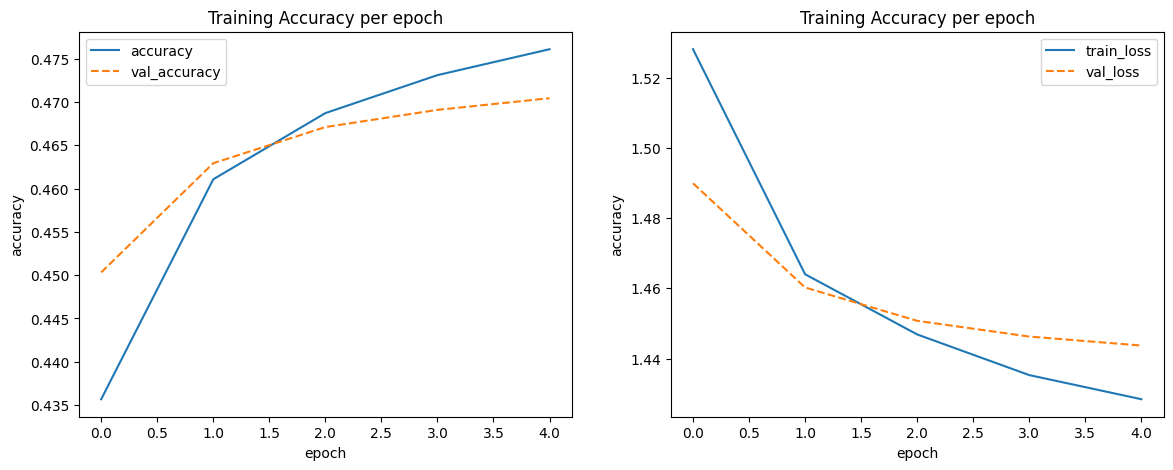

In [107]:
plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.plot(training_log['epoch'][:],training_log['accuracy'][:],  label='accuracy')
plt.plot(training_log['epoch'][:],training_log['val_accuracy'][:], '--',  label='val_accuracy')
plt.title("Training Accuracy per epoch") # title
plt.ylabel("accuracy") # y label
plt.xlabel("epoch") # x label
plt.legend()

plt.subplot(122)
plt.plot(training_log['epoch'][:],training_log['loss'][:],  label='train_loss')
plt.plot(training_log['epoch'][:],training_log['val_loss'][:], '--',  label='val_loss')
plt.title("Training Accuracy per epoch") # title
plt.ylabel("accuracy") # y label
plt.xlabel("epoch") # x label
plt.legend()

plt.show()

### 1.7 save model

In [108]:
# save model
model_json = model.to_json()
with open("models/model_v10.json", "w") as json_file:
    json_file.write(model_json)


In [109]:
model.save_weights("models/model_v10.h5")
print("Saved model to disk")

Saved model to disk


### 1.8 validation 

In [110]:
def eval(df, trained_encoder):
    batch_size = 32
    # data preparations
    x_tokenize = tokenizer.texts_to_sequences(df['text'].values)
    x_padding = pad_sequences(x_tokenize, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
    print('text after tokenize and padding shape:', x_padding.shape)
    
    # generate predictions
    y_prediction = model.predict(x_padding, batch_size=batch_size)
     # decode prediction results into labels
    y_prediction_decoded = label_decode(trained_encoder, y_prediction)
    
    return y_prediction_decoded
    

In [112]:
# label_encoder train by train[text]
train_df_1, validation_df = train_test_split(train_df, test_size = 0.1, random_state = 42)

y_pred = eval(validation_df, label_encoder)

text after tokenize and padding shape: (145557, 40)
4549/4549 [==============================] - 6s 1ms/step


In [115]:
train_df

,tweet_id,text,identification,emotion
0,0x376b20,"People who post ""add me on #Snapchat"" must be ...",train,anticipation
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #...",train,sadness
2,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>,train,fear
3,0x1d755c,@RISKshow @TheKevinAllison Thx for the BEST TI...,train,joy
4,0x2c91a8,Still waiting on those supplies Liscus. <LH>,train,anticipation
...,...,...,...,...
1455558,0x321566,I'm SO HAPPY!!! #NoWonder the name of this sho...,train,joy
1455559,0x38959e,In every circumtance I'd like to be thankful t...,train,joy
1455560,0x2cbca6,there's currently two girls walking around the...,train,joy
1455561,0x24faed,"Ah, corporate life, where you can date <LH> us...",train,joy


In [113]:
train_df_1

,tweet_id,text,identification,emotion
207436,0x2c0e9b,Blessed to see another 24 Good Morning Happy S...,train,joy
591410,0x228120,Life ain't shit without love in it❤ <LH> #Life...,train,joy
626489,0x253af0,"I got 1,2,3,4,5,6,7,8 zeros in my bank account...",train,sadness
483944,0x2b380c,@DavidMDrucker <LH> What the final product ...,train,sadness
850624,0x2e4257,#Neighbours playing drums at 8am - work shifts...,train,anger
...,...,...,...,...
259178,0x1d5c9e,"And above all these things put on charity, whi...",train,joy
1414414,0x2cc602,@kylegriffin1 Still a devastating poll for Tru...,train,sadness
131932,0x2ec9a9,"@BebeNeuwirth Ohhh, tears! <LH>",train,joy
671155,0x2d3f18,Sponsor shirts are completed and Spirit Gear h...,train,joy


In [114]:
validation_df

,tweet_id,text,identification,emotion
970345,0x2b605f,Been a #week now #since I <LH> my #Mom. I #mis...,train,surprise
1145883,0x2eaf42,"Follow our Librarian, Ms. Bird 🐦 for more info...",train,joy
468264,0x333365,Wonder if the guys who skate in Foxboro over t...,train,joy
949718,0x28af74,"@vanillablack1 Bloody <LH> puts it mildly, wil...",train,joy
982592,0x3868ce,Beat the Dolphins next week and we are back to...,train,joy
...,...,...,...,...
112536,0x37facc,@AnthemGameHub Thank you for the heads up. Can...,train,joy
257993,0x21e5f9,<LH> <LH> Romans9:25This is what he says in th...,train,anticipation
365502,0x388f2e,This mornings call literally got me feeling 😪😐...,train,sadness
992936,0x2d3468,@Mig007M @iLoveiDevices @DineshDSouza Libs obs...,train,sadness


In [118]:
# ground truth binary->literal form
y_groundtruth = validation_df['emotion'].values


print('y_prediction.shape: ', y_pred.shape)
print('y_test_ground_truth.shape: ', y_groundtruth.shape)
print(classification_report(y_true=y_groundtruth, y_pred=y_pred))

y_prediction.shape:  (145557,)
y_test_ground_truth.shape:  (145557,)
              precision    recall  f1-score   support

       anger       0.75      0.09      0.16      3964
anticipation       0.55      0.46      0.50     24975
     disgust       0.34      0.20      0.25     13883
        fear       0.60      0.18      0.28      6406
         joy       0.48      0.79      0.60     51452
     sadness       0.34      0.39      0.37     19284
    surprise       0.97      0.09      0.17      4937
       trust       0.55      0.20      0.30     20656

    accuracy                           0.47    145557
   macro avg       0.57      0.30      0.33    145557
weighted avg       0.50      0.47      0.43    145557



### 1.9 evaluation

In [119]:
y_pred = eval(test_df, label_encoder)

text after tokenize and padding shape: (411972, 40)
12875/12875 [==============================] - 11s 852us/step


In [120]:
y_pred[:10]

array(['joy', 'anticipation', 'anticipation', 'joy', 'joy', 'sadness',
       'joy', 'anticipation', 'joy', 'joy'], dtype=object)

In [121]:
dir_data = 'Twitter_kaggle_data'
f_sample_sub = os.path.join(dir_data, 'sampleSubmission.csv')
sample_sub = pd.read_csv(f_sample_sub)

In [122]:
# transform into dataframe to submit to kaggle
sample_sub['emotion'] = y_pred
sample_sub.head()

,id,emotion
0,0x2c7743,joy
1,0x2c1eed,anticipation
2,0x2826ea,anticipation
3,0x356d9a,joy
4,0x20fd95,joy


In [123]:
f_sample_sub = os.path.join(dir_data, 'submission/submission_v10.csv')
sample_sub.to_csv(f_sample_sub, index=False)


 -----  

## Method2. Use pre-trained model

In [17]:
import datasets
from datasets import Dataset, DatasetDict

train_dataset = Dataset.from_pandas(train_df[['text', 'emotion']])
train_dataset = train_dataset.remove_columns("__index_level_0__")

In [18]:
print(train_dataset)
print(train_dataset[:5])

Dataset({
    features: ['text', 'emotion'],
    num_rows: 1455563
})
{'text': ['People who post "add me on #Snapchat" must be dehydrated. Cuz man.... that\'s <LH>', '@brianklaas As we see, Trump is dangerous to #freepress around the world. What a <LH> <LH> #TrumpLegacy.  #CNN', 'Now ISSA is stalking Tasha 😂😂😂 <LH>', '@RISKshow @TheKevinAllison Thx for the BEST TIME tonight. What stories! Heartbreakingly <LH> #authentic #LaughOutLoud good!!', 'Still waiting on those supplies Liscus. <LH>'], 'emotion': ['anticipation', 'sadness', 'fear', 'joy', 'anticipation']}


In [19]:
test_dataset = Dataset.from_pandas(test_tmp[['text', 'emotion']])
test_dataset = test_dataset.remove_columns("__index_level_0__")
test_dataset

Dataset({
    features: ['text', 'emotion'],
    num_rows: 411972
})

In [20]:
train_dataset['text'][:4]

['People who post "add me on #Snapchat" must be dehydrated. Cuz man.... that\'s <LH>',
 '@brianklaas As we see, Trump is dangerous to #freepress around the world. What a <LH> <LH> #TrumpLegacy.  #CNN',
 'Now ISSA is stalking Tasha 😂😂😂 <LH>',
 '@RISKshow @TheKevinAllison Thx for the BEST TIME tonight. What stories! Heartbreakingly <LH> #authentic #LaughOutLoud good!!']

### 2.0 load pre-trained model

In [21]:
MODEL_NAME = "cardiffnlp/twitter-roberta-base-emotion"

In [22]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
### 1.0 OneHotEncoder to ffit emotion feature

In [23]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

encoder = OneHotEncoder(handle_unknown='ignore')
label_data = np.array(train_dataset["emotion"]).reshape(-1,1)
print(label_data)
encoder.fit(label_data)

[['anticipation']
 ['sadness']
 ['fear']
 ...
 ['joy']
 ['joy']
 ['joy']]


OneHotEncoder(handle_unknown='ignore')

In [24]:
print(encoder.transform(label_data).toarray()[0])


[0. 1. 0. 0. 0. 0. 0. 0.]


In [25]:
LABEL_COUNT = len(encoder.categories_[0])
print(LABEL_COUNT)

8


### 2.1 preprocess for train, test set

In [26]:
def preprocess(dataslice):
    """ Input: a batch of your dataset
        Example: { 'text': [['sentence1'], ['setence2'], ...],
                   'label': ['label1', 'label2', ...] }
    """
    
    # [ TODO ] use your tokenizor and encoder to get sentence embeddings and encoded labels

    tokenized = tokenizer(dataslice['text'])
    emotion_list = np.array(dataslice['emotion']).reshape((-1, 1))
    tokenized['label'] = encoder.transform(emotion_list).toarray()
    return  tokenized
    """ Output: a batch of processed dataset
        Example: { 'input_ids': ...,
                   'attention_masks': ...,
                   'label': ... }
    """

In [27]:
# map the function to the whole dataset
print(train_dataset)
train_processed_data = train_dataset.map(preprocess,    # your processing function
                             batched = True # Process in batches so it can be faster
                            )

print(train_dataset[0])

Dataset({
    features: ['text', 'emotion'],
    num_rows: 1455563
})


  0%|          | 0/1456 [00:00<?, ?ba/s]

{'text': 'People who post "add me on #Snapchat" must be dehydrated. Cuz man.... that\'s <LH>', 'emotion': 'anticipation'}


In [28]:
print(test_dataset)
test_processed_data = test_dataset.map(preprocess,    # your processing function
                             batched = True # Process in batches so it can be faster
                            )

print(test_dataset[0])

Dataset({
    features: ['text', 'emotion'],
    num_rows: 411972
})


  0%|          | 0/412 [00:00<?, ?ba/s]

{'text': 'When your friends offer to bring you food 😭💘 #loyal #real <LH>', 'emotion': 'surprise'}


### 2.2 create data_collator for padding, parameter in Trainer

In [30]:

from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [31]:
train_processed_data

Dataset({
    features: ['text', 'emotion', 'input_ids', 'attention_mask', 'label'],
    num_rows: 1455563
})

In [32]:
test_processed_data

Dataset({
    features: ['text', 'emotion', 'input_ids', 'attention_mask', 'label'],
    num_rows: 411972
})

In [34]:
torch.LongTensor(8)

tensor([267108448, 267108448,         0,         0, 399092224,        -1,
                0,         0])

In [33]:
model = RobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=LABEL_COUNT, ignore_mismatched_sizes=True)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
print(train_processed_data[0])

{'text': 'People who post "add me on #Snapchat" must be dehydrated. Cuz man.... that\'s <LH>', 'emotion': 'anticipation', 'input_ids': [0, 4763, 54, 618, 22, 4917, 162, 15, 849, 41513, 29465, 113, 531, 28, 36410, 8358, 4, 230, 4987, 313, 17220, 14, 18, 28696, 574, 725, 15698, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'label': [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


### 2.3 split train/validation

In [36]:
train_validation_dataset = train_processed_data.train_test_split(train_size=0.8)

In [37]:
print(train_validation_dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'emotion', 'input_ids', 'attention_mask', 'label'],
        num_rows: 1164450
    })
    test: Dataset({
        features: ['text', 'emotion', 'input_ids', 'attention_mask', 'label'],
        num_rows: 291113
    })
})


### 2.4 Trainer

In [38]:
from transformers import TrainingArguments, Trainer

In [39]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [50]:
# [ TODO ] set and tune your training properties

# GloVe twitter
OUTPUT_DIR = 'Twitter_kaggle_data/model/bert4'
LEARNING_RATE = 2e-5
BATCH_SIZE =  8
EPOCH = 1

training_args = TrainingArguments(
    output_dir = OUTPUT_DIR,
    learning_rate = LEARNING_RATE,
    num_train_epochs = EPOCH,
    save_steps=100000,
    per_device_train_batch_size = BATCH_SIZE,
    per_device_eval_batch_size = BATCH_SIZE,
    
    
    # evaluation_strategy="epoch"
    # you can set more parameters here if you want
)

# now give all the information to a trainer
trainer = Trainer(
    # set your parameters here
    model = model,
    #compute_metrics=compute_metrics,
    args = training_args,
    data_collator = data_collator,
    train_dataset = train_validation_dataset['train'],
    eval_dataset=train_validation_dataset['test'],
    tokenizer=tokenizer
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [51]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text, emotion. If text, emotion are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
/home/nlplab/yhc/dataminig/env/dataminingLab/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1164450
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 145557
  Number of trainable parameters = 124651784


Step,Training Loss
500,0.183100
1000,0.174700
1500,0.178900
2000,0.179600
2500,0.171800
3000,0.173500
3500,0.175000
4000,0.169300
4500,0.178700
5000,0.170800


Saving model checkpoint to Twitter_kaggle_data/model/bert4/checkpoint-100000
Configuration saved in Twitter_kaggle_data/model/bert4/checkpoint-100000/config.json
Model weights saved in Twitter_kaggle_data/model/bert4/checkpoint-100000/pytorch_model.bin
tokenizer config file saved in Twitter_kaggle_data/model/bert4/checkpoint-100000/tokenizer_config.json
Special tokens file saved in Twitter_kaggle_data/model/bert4/checkpoint-100000/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=145557, training_loss=0.1611117395846936, metrics={'train_runtime': 5317.8475, 'train_samples_per_second': 218.97, 'train_steps_per_second': 27.371, 'total_flos': 2.898009886815552e+16, 'train_loss': 0.1611117395846936, 'epoch': 1.0})

### 2.5 save and load finetuned model as mymodel

In [52]:
model.save_pretrained('Twitter_kaggle_data/model/bert4/config')

Configuration saved in Twitter_kaggle_data/model/bert4/config/config.json
Model weights saved in Twitter_kaggle_data/model/bert4/config/pytorch_model.bin


In [53]:
# [ TODO ] load the model that you saved
from transformers import AutoConfig, AutoModelForSequenceClassification

#config = AutoConfig.from_pretrained("model/finetuned/config.json")
mymodel = AutoModelForSequenceClassification.from_pretrained('Twitter_kaggle_data/model/bert4/config')


loading configuration file Twitter_kaggle_data/model/bert4/config/config.json
Model config RobertaConfig {
  "_name_or_path": "Twitter_kaggle_data/model/bert4/config",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,

### 2.6 evaluation on validation set

In [54]:
import torch
from torch import nn

predictions, labels, metrics = trainer.predict(train_validation_dataset["test"])
#print(predictions[:10])

predictions = torch.from_numpy(predictions)
predictions_after_softmax = nn.functional.softmax(predictions, dim = -1)


result = torch.argmax(predictions_after_softmax,dim=1).to("cuda:0")


print(result)
pred_labels = torch.nn.functional.one_hot(result)
pred_emotion = encoder.inverse_transform(pred_labels.cpu()).flatten()
# get predictions
print("pred_level",pred_emotion[:10])
print("label",encoder.inverse_transform(labels)[:10])


The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text, emotion. If text, emotion are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 291113
  Batch size = 8


tensor([1, 4, 4,  ..., 5, 3, 5], device='cuda:0')
pred_level ['anticipation' 'joy' 'joy' 'trust' 'disgust' 'anticipation' 'joy' 'fear'
 'joy' 'anticipation']
label [['anticipation']
 ['disgust']
 ['joy']
 ['trust']
 ['sadness']
 ['anticipation']
 ['joy']
 ['joy']
 ['joy']
 ['anticipation']]


In [55]:
ground_truth = encoder.inverse_transform(train_validation_dataset["test"]["label"])
print(ground_truth[:10])

[['anticipation']
 ['disgust']
 ['joy']
 ['trust']
 ['sadness']
 ['anticipation']
 ['joy']
 ['joy']
 ['joy']
 ['anticipation']]


In [57]:
correct_count = 0
for idx, emotion in enumerate(pred_emotion):
    if emotion == ground_truth[idx]:
        correct_count += 1
print(len(pred_emotion))
print(len(ground_truth))
print(correct_count/len(pred_emotion))

291113
291113
0.684737541779309


### 2.7 prediction on test

In [62]:
from torch import nn

predictions, labels, metrics = trainer.predict(test_processed_data)
print(predictions)
predictions = torch.from_numpy(predictions)
predictions_after_softmax = nn.functional.softmax(predictions, dim = -1)


result = torch.argmax(predictions_after_softmax,dim=1)
pred_labels = torch.nn.functional.one_hot(result)
pred_emotion = encoder.inverse_transform(pred_labels.cpu()).flatten()

print("pred_level",pred_emotion[:10])

The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text, emotion. If text, emotion are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 411972
  Batch size = 8


[[-8.214266   -4.5631313  -6.876572   ... -5.8082085  -6.1709623
  -0.8167434 ]
 [-7.8122144  -1.3147477  -7.437986   ... -6.169711   -6.177668
  -1.2701539 ]
 [-4.0105357  -3.5110514  -1.4310974  ...  0.04336232 -2.829834
  -3.2141278 ]
 ...
 [-4.648582   -3.9211845  -0.10680941 ... -0.6926084  -2.1498501
  -4.285334  ]
 [-5.452918   -3.3196917  -3.2263513  ... -2.8650122  -4.1204977
  -0.92678785]
 [-4.0121727  -1.6751281  -2.922168   ...  0.48816577 -4.5398865
  -2.9444232 ]]
pred_level ['joy' 'joy' 'sadness' 'trust' 'joy' 'sadness' 'joy' 'anticipation' 'joy'
 'trust']


In [66]:
pred_labels

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        ...,
        [0, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0]])

In [67]:
sampleSubmission = pd.read_csv("Twitter_kaggle_data/sampleSubmission.csv")
sampleSubmission['emotion'] = pred_emotion

In [70]:
sampleSubmission.head()

dir_data = 'Twitter_kaggle_data'
f_sample_sub = os.path.join(dir_data, 'submission/submission_pretrained_v11.csv')
sampleSubmission.to_csv(f_sample_sub, index=False)